# Chapter 7: Scraping Google Play Reviews

#### Imports

In [5]:
!pip install -qq google_play_scraper

     |████████████████████████████████| 52 kB 824 kB/s 


In [97]:
# files
import json
import pandas as pd

#progress bar 
from tqdm import tqdm 

#formatters 
from pygments import highlight 
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

# scraper
from google_play_scraper import Sort, reviews, app

# plotting 
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20,8

#linalg
import numpy as np


#### Defining Apps to Scrape


In [8]:
# we define the languages and the country 
LANGUAGE,COUNTRY = 'en','us'
# we will use some of the top apps from the US 
# this data comes from AppAnnie which is a paid service :(
app_packages=[
              'com.anydo','com.todoist', 'com.ticktick.task',
              'com.habitrpg.android.habitica', 'cc.forestapp', 
              'com.oristats.habitbull', 'com.levor.liferpgtasks', 
              'com.habitnow', 'com.microsoft.todos', 'prox.lab.calclock',
              'com.gmail.jmartindev.timetune', 'com.artfulagenda.app',
              'com.tasks.android', 'com.appgenix.bizcal', 'com.appxy.planner'
]

#### Testing the Google Play Scraper

In [ ]:
# lets see what information the google play scraper gives us 
# a random sample
import numpy as np
sample = np.random.choice(app_packages)
print(sample)
# info 
info = app(sample, lang=LANGUAGE, country=COUNTRY)
# lets check how many keys we have --> 52 keys! 
print(len(info.keys()))
del info['comments'] # delete the comments 
info # look at the data

#### Extracting Google Play Reviews

In [29]:
def collect_info(LIST_OF_APPS,LANGUAGE,COUNTRY):
  '''
  Helper function which extracts the information from a given app-name
  returns a json file with 52 keys, we will use 51 because we are 
  removing the comments section! 
  '''
  app_info = []
  for apps in tqdm(LIST_OF_APPS):
    info = app(apps, lang=LANGUAGE, country=COUNTRY)
    del info['comments']
    app_info.append(info)
  return app_info

# also make a pretty printer 

def pretty_print_json(JSON_OBJECT):
  '''
   Color codes the keys and the values in a JSON object 
  '''
  json_file = json.dumps(
                          JSON_OBJECT,
                         indent=2,
                         sort_keys=True,
                         default=str
                            )
  print(highlight(json_file, JsonLexer(), TerminalFormatter()))

In [31]:
# creating the app info list 
app_info = collect_info(app_packages, LANGUAGE, COUNTRY)

100%|██████████| 15/15 [00:02<00:00,  5.32it/s]


In [ ]:
# now we can pretty print the file 
# lets get a random sample 
random_app = np.random.choice(app_info)

pretty_print_json(random_app)

#### Checking out the reviews part of GPS

In [40]:
# now we need to extract the reviews 
revs,k = reviews(sample, lang=LANGUAGE, country=COUNTRY,sort=Sort.MOST_RELEVANT)
print(len(revs))

len(revs[0])

100


10

#### Extracting the Reviews - ACTUALLY!

In [43]:
def extract_gps_reviews(LIST_OF_APPS,LANGUAGE, COUNTRY):
  # instantiate an empty list 
  l = []
  for apps in tqdm(LIST_OF_APPS):
    # we want to go in order for each of the scores 
    for val in list(range(1,6)):
      for sort_order in [Sort.MOST_RELEVANT,Sort.NEWEST]:
        REVIEWS,_ = reviews(apps, 
                            lang=LANGUAGE, 
                            country=COUNTRY,
                            sort = sort_order, 
                            count = 200 if val == 3 else 100, 
                            filter_score_with = val)
        for k in REVIEWS:
          k['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
          k['appId'] = apps
        l.extend(REVIEWS)
  
  return l

In [44]:
app_reviews = extract_gps_reviews(app_packages, LANGUAGE, COUNTRY)

100%|██████████| 15/15 [01:06<00:00,  4.47s/it]


In [45]:
df = pd.DataFrame(app_reviews)
df.to_csv('GOOGLE_PLAY_REVIEWS.csv')

In [46]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOH85sc18Ajgcgj6-IGmA7Gp34fVsrbyBJ274IZ...,Anthony Duarte,https://play-lh.googleusercontent.com/a-/AOh14...,"As a programmer, this is absolutely the most l...",1,21,5.15.3.0,2022-01-22 11:33:48,We are sorry you feel this way! We encourage u...,2022-01-24 09:59:17,most_relevant,com.anydo
1,gp:AOqpTOGxyMqOStnhbQ_mLfnLUfd1DHAt5uRXqDNArML...,Through Genesis,https://play-lh.googleusercontent.com/a/AATXAJ...,Redoing my review after messaging with the app...,1,18,5.15.3.0,2022-01-22 13:34:47,"Any.do is a free app, 90% of the app is comple...",2022-01-24 09:58:12,most_relevant,com.anydo
2,gp:AOqpTOHgR1qnD3AZbHvKJ6-BbO4pMkokJS2JT1UvdVI...,Glenn Anderson,https://play-lh.googleusercontent.com/a/AATXAJ...,EDITED. So the app works as expected. It does ...,1,12,5.15.3.0,2022-01-22 00:29:36,For any questions feel free to contact us at w...,2022-01-11 15:51:10,most_relevant,com.anydo
3,gp:AOqpTOH_GtAiezLqm0tHyquE1arU2C_L__IFTeqJxsg...,Bob Garcia,https://play-lh.googleusercontent.com/a-/AOh14...,I liked this app until recently. I discovered ...,1,77,5.15.3.0,2021-12-06 00:55:00,Sorry you feel this way Bob. As explained by o...,2021-12-06 12:36:53,most_relevant,com.anydo
4,gp:AOqpTOEvo7a7-HX3iYDQ-FPQOgQUw-kA5ajCkrf2ENy...,Edward Jr. Kelley,https://play-lh.googleusercontent.com/a/AATXAJ...,"No family plan, won't use this app at all!! Wh...",1,4,5.15.3.0,2022-01-18 07:44:44,"We also occasionally offer promotions, we enco...",2022-01-20 15:23:40,most_relevant,com.anydo


#### EDA

In [61]:
# checking the number of samples we have 
N_SAMPLES = df.shape[0]
txt = f"The number of samples is {N_SAMPLES}\n"
print(txt)

# also checking the columns that we have 
[x for x in df.columns]

The number of samples is 16914



['reviewId',
 'userName',
 'userImage',
 'content',
 'score',
 'thumbsUpCount',
 'reviewCreatedVersion',
 'at',
 'replyContent',
 'repliedAt',
 'sortOrder',
 'appId']

In [64]:
# are all the usernames unique?
all_users = df['userName'].values
num_users = len(all_users)
print(f"The number of users is {num_users}")

# now lets check the unique users 
num_users_unique = len(df['userName'].unique())
print(f"The number of unique users is {num_users_unique}")

# what is the difference 
diffs = abs(num_users - num_users_unique)
print(f"The number of duplicated users is {diffs}")

The number of users is 16914
The number of unique users is 12665
The number of duplicated users is 4249


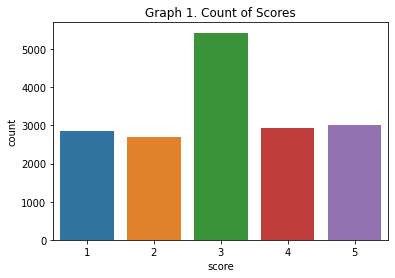

In [51]:

g = sns.countplot(x='score',data=df)
g.set_title('Graph 1. Count of Scores')
plt.show()

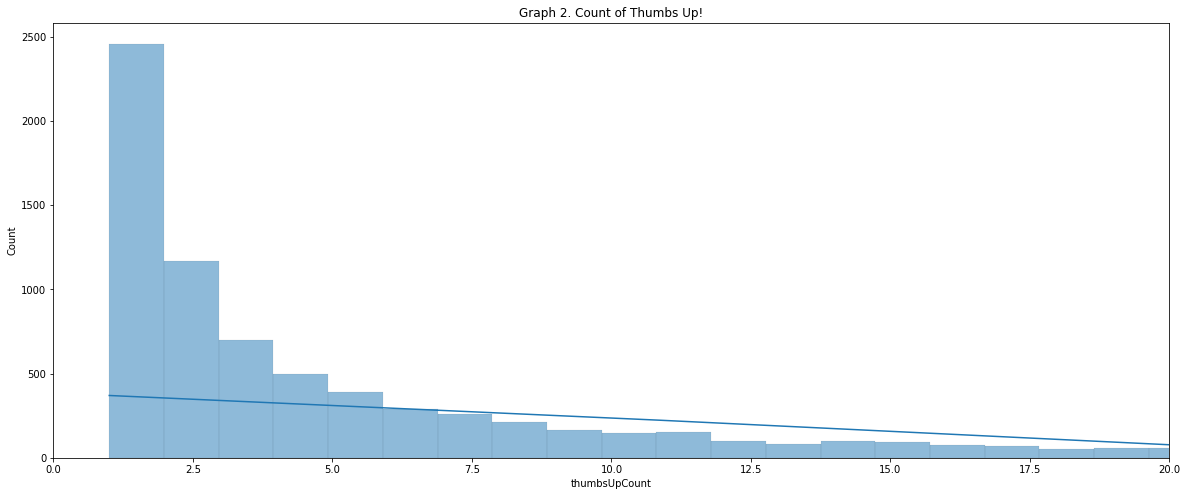

In [109]:
# filter the df for values greater than 0 
filtered_df = df[df['thumbsUpCount'] != 0]
g = sns.histplot(filtered_df['thumbsUpCount'],kde=True)
g.set_xlim([0,20])
g.set_title('Graph 2. Count of Thumbs Up!')
plt.show()

In [65]:
df.dtypes

reviewId                        object
userName                        object
userImage                       object
content                         object
score                            int64
thumbsUpCount                    int64
reviewCreatedVersion            object
at                      datetime64[ns]
replyContent                    object
repliedAt               datetime64[ns]
sortOrder                       object
appId                           object
dtype: object

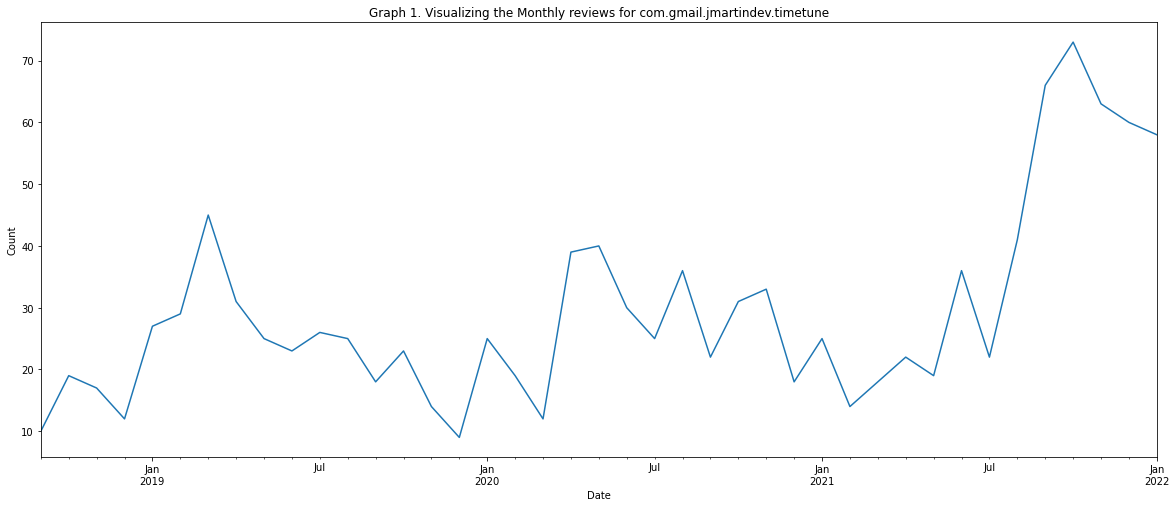

In [95]:
'''
RESAMPLING DOCUMENTATION HERE 
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
D = Day
W = Weekly 
M = Monthly 
A, Y = Annualy / Yearly
'''

def visualize_reviews(DATAFRAME, SAMPLING_TYPE, APP_ID):
  # first we create a filtered dataframe 
  NEW_DF = DATAFRAME[DATAFRAME['appId'] == APP_ID].copy()
  # resample into the desired type 
  # title text
  d = {
       'D':'Daily',
       'W':'Weekly',
       'M':'Monthly',
       'A':'Yearly',
       'Y':'Yearly'
       } 
  title_text = f'Graph 1. Visualizing the {d[SAMPLING_TYPE]} reviews for {APP_ID}'
  NEW_DF.resample(SAMPLING_TYPE,on='at')['reviewId'].count().plot(
                                                                  title=title_text,
                                                                  xlabel='Date',
                                                                  ylabel='Count'
                                                                  )
  plt.show()
# visualizing it 
visualize_reviews(df, 'M', sample)

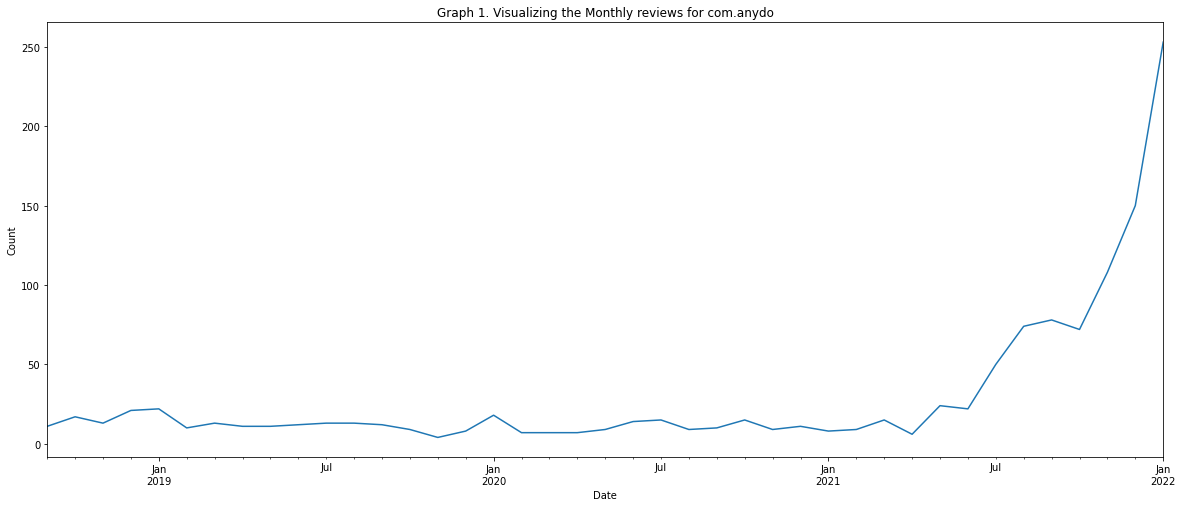

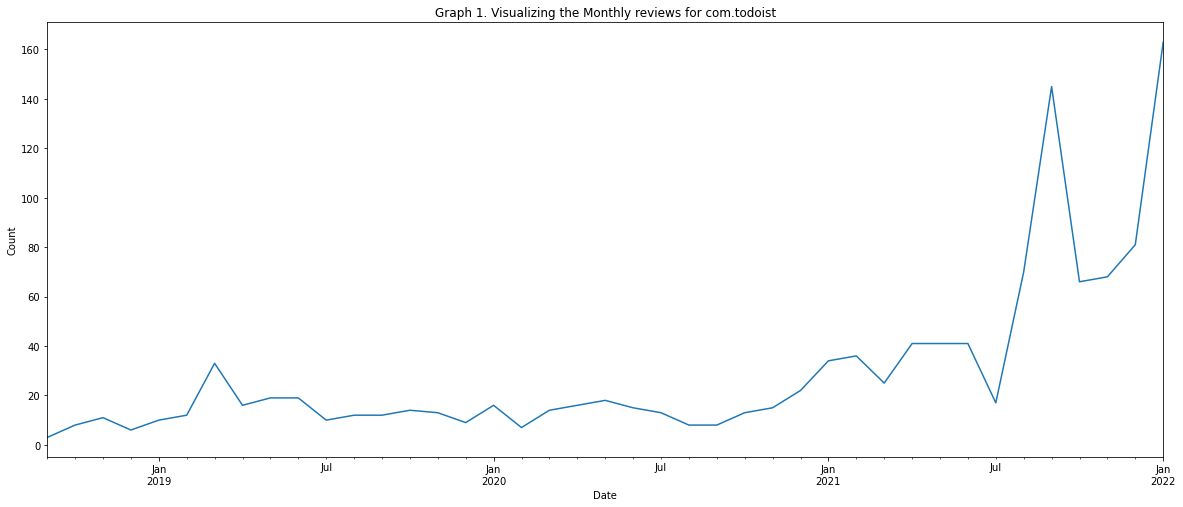

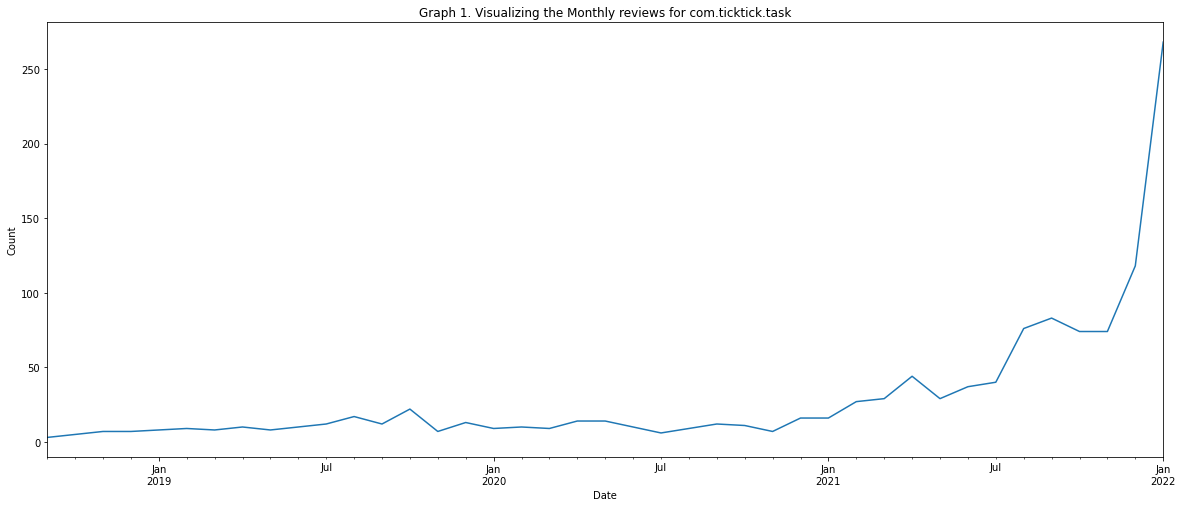

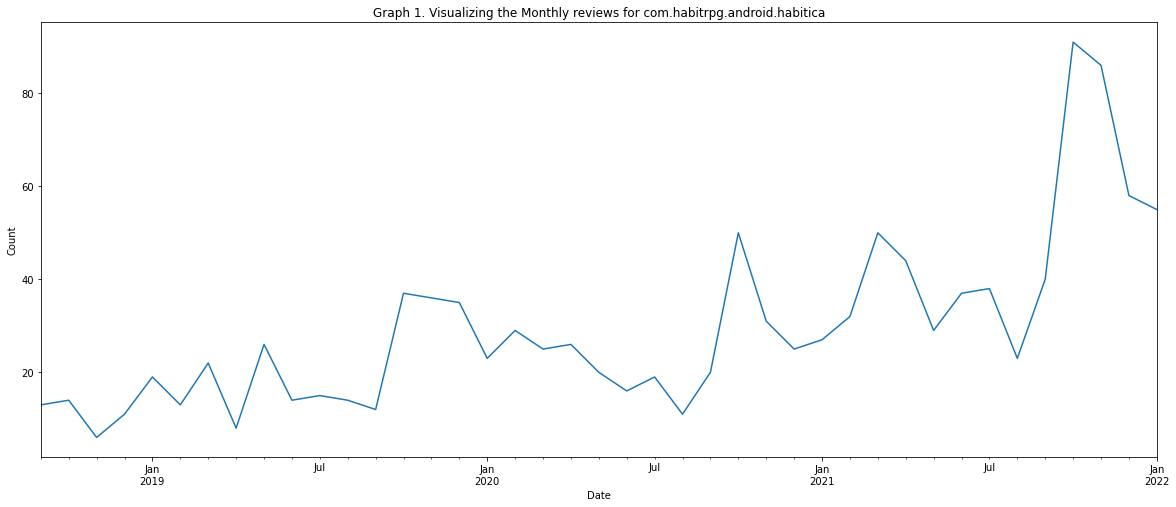

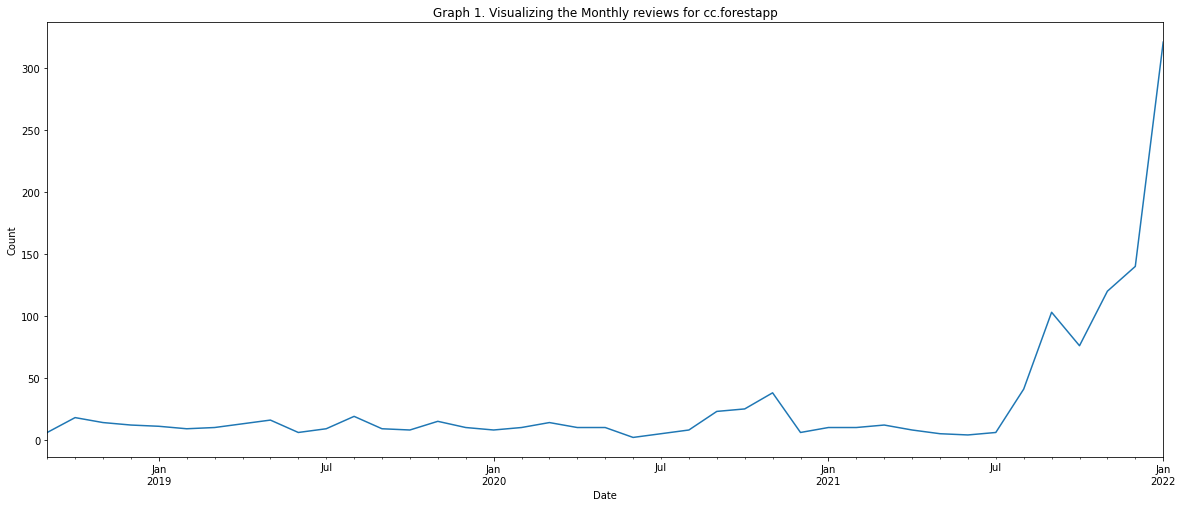

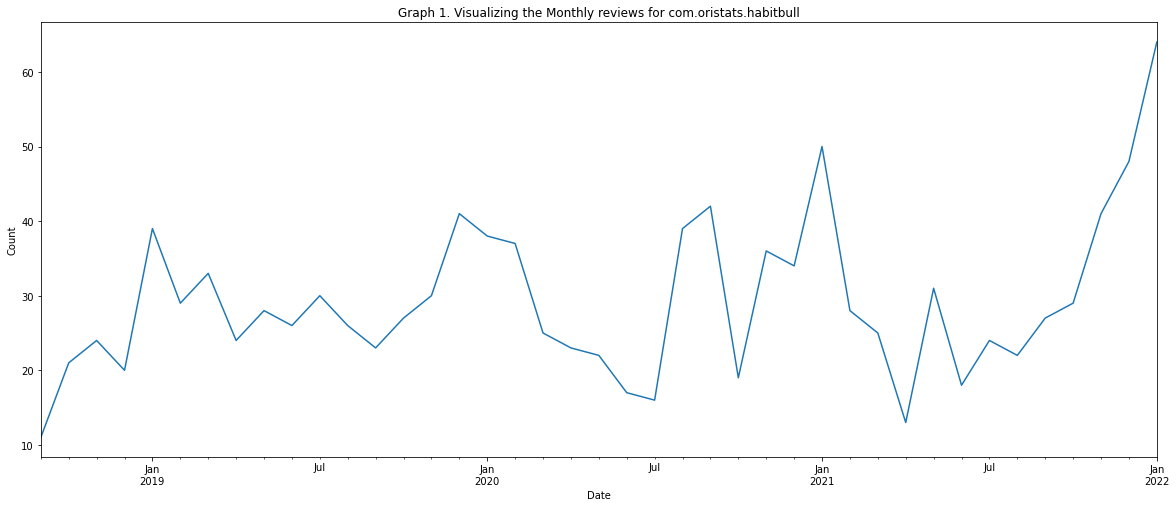

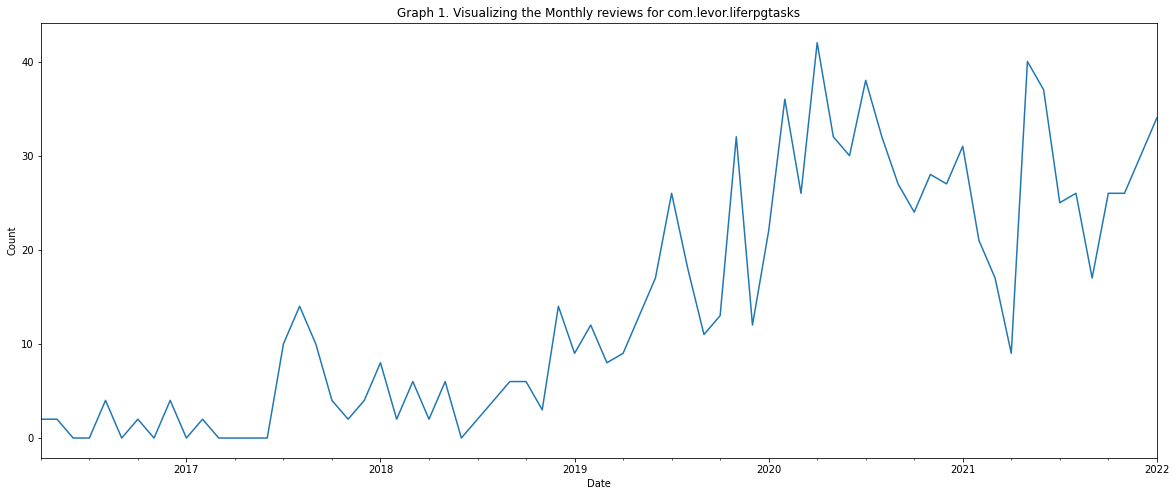

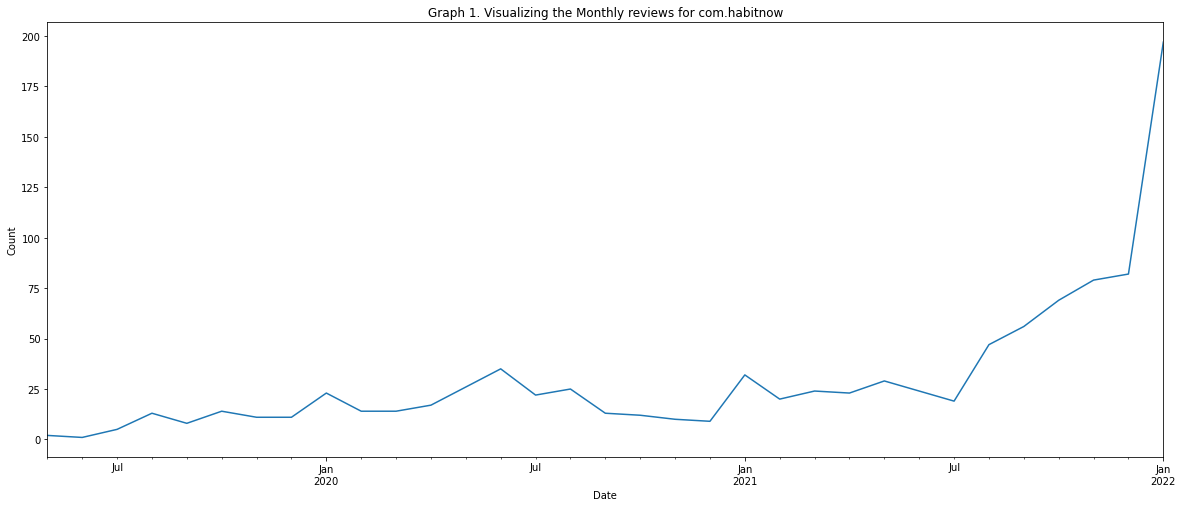

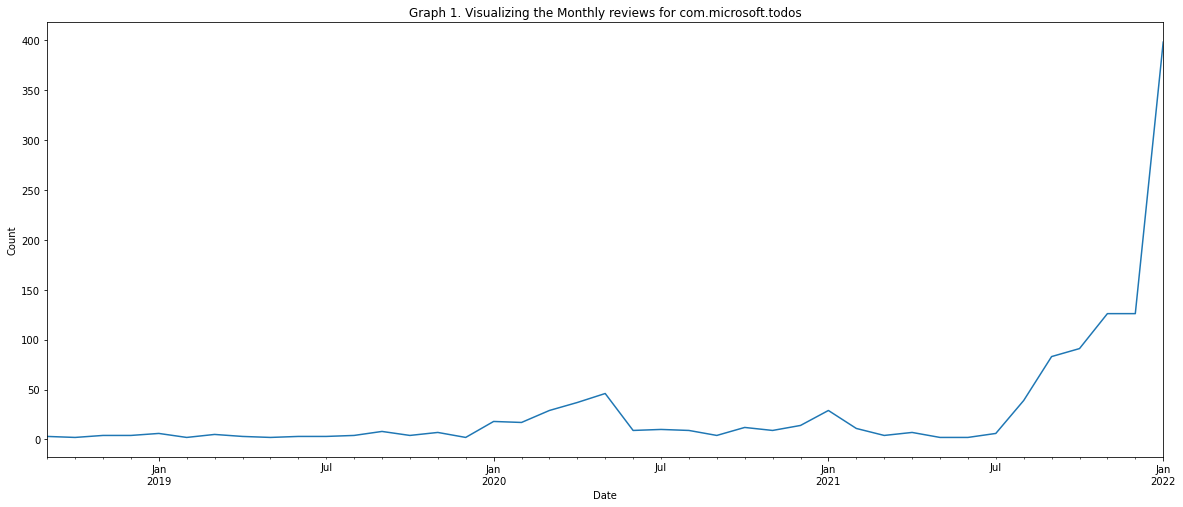

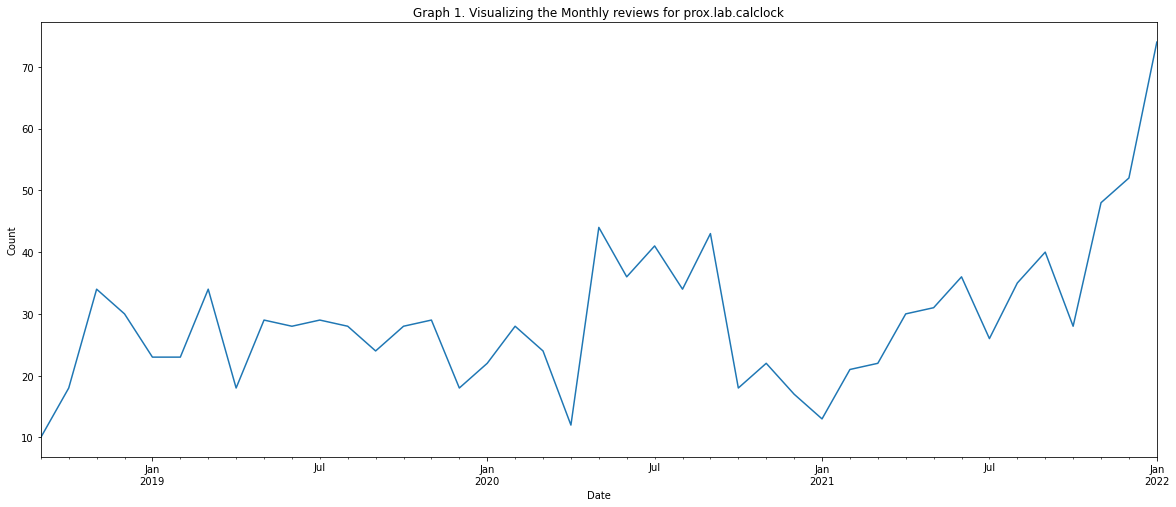

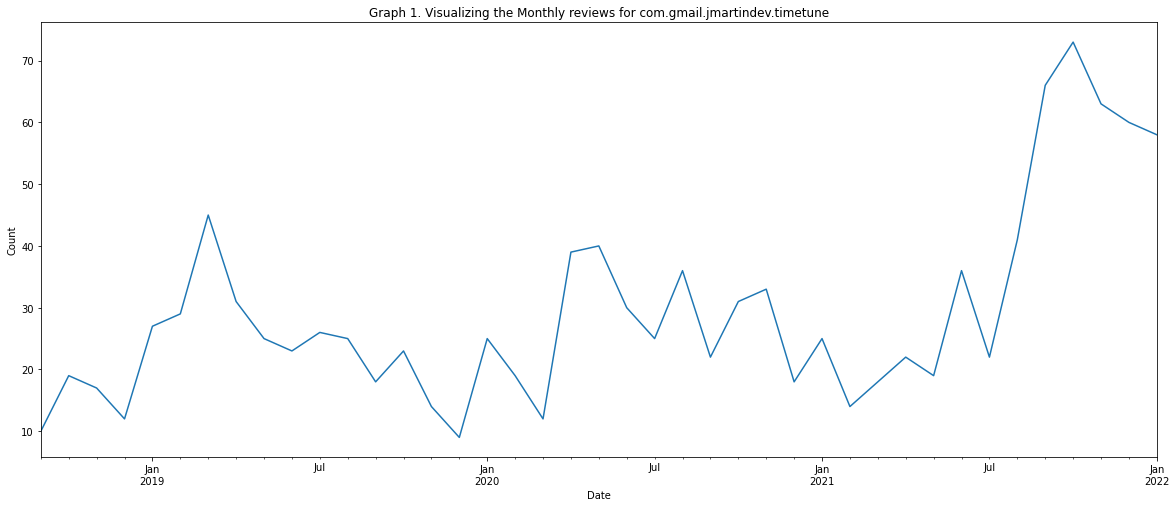

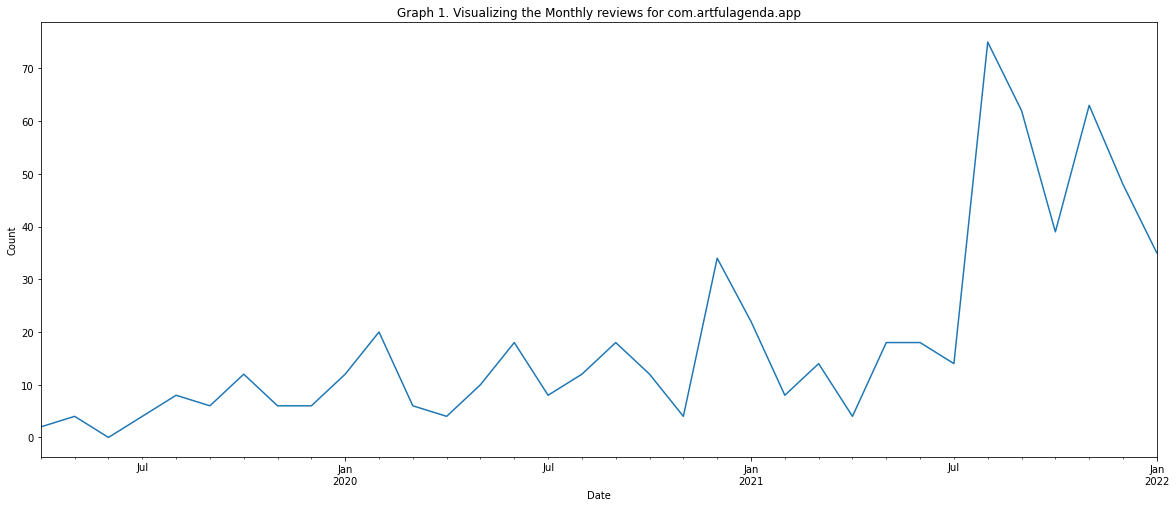

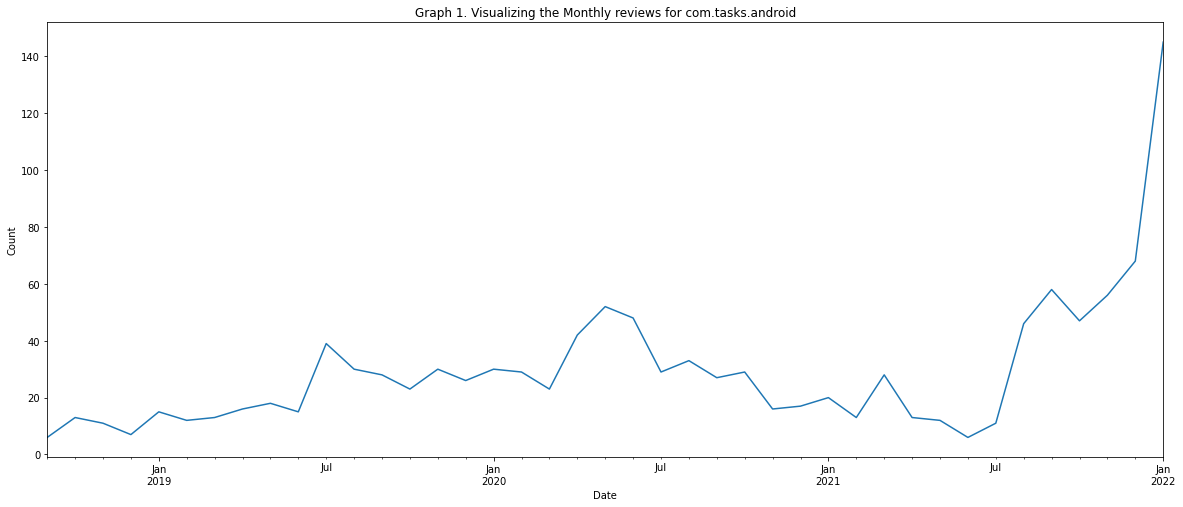

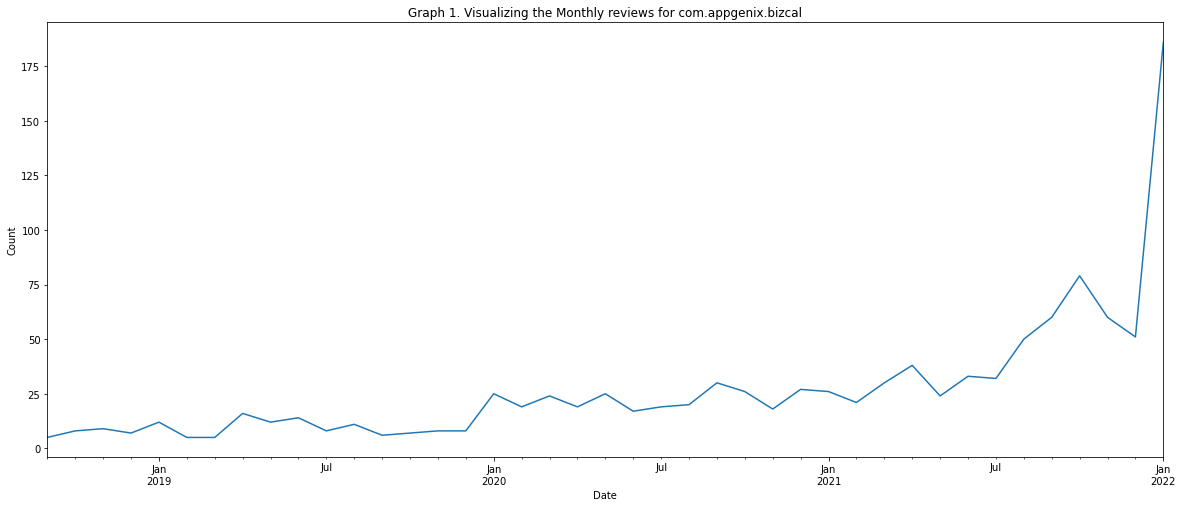

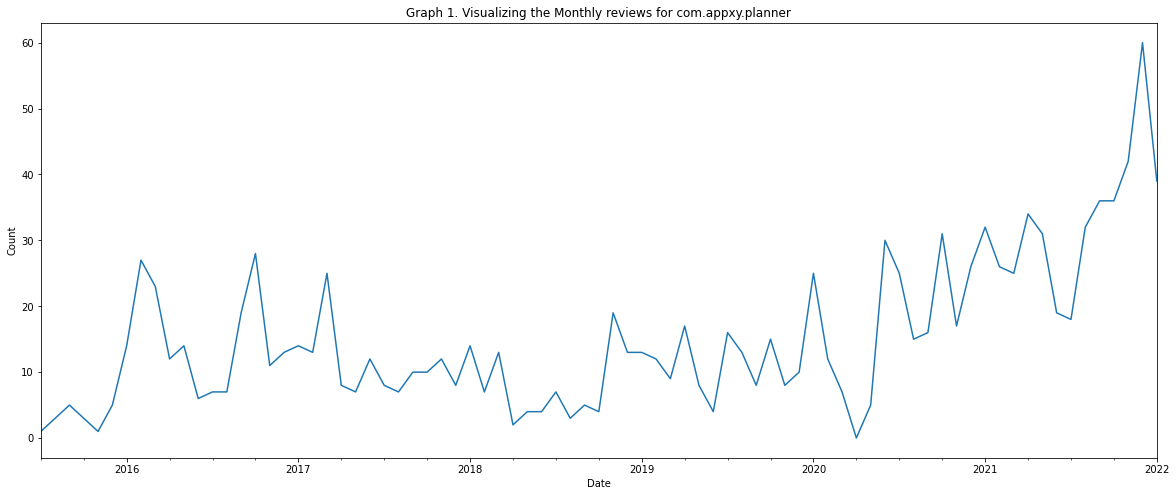

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [96]:
# looking at the graph for all the apps 
[visualize_reviews(df,'M',x) for x in app_packages]

In [110]:
len(df)

16914